# The Perceptron

Let us start by importing some of the libraries we will need and set up our notebook session:

In [1293]:
from __future__ import print_function
from __future__ import division

import math

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## A Basic Perceptron

Here goes the blueprint of our perceptron, encoded as a plain Python object, as well as a single auxiliary function. Below we will walk through the details of each code components.

In [1294]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

class Perceptron:
    def __init__(self, nb_features=None):
        self.weights = None
        self.nb_features = nb_features # i.e. the nb of incoming connections from other neurons
    
    def set_weights(self, weights=None):
        if weights:
            self.weights = weights
        else:
            self.weights = np.ones(self.nb_features)
    
    def predict(self, feature_vectors, squash=False):
        scores = []
        for fv in feature_vectors:
            s = 0.0
            for i in range(self.nb_features):
                s += self.weights[i] * fv[i]
            scores.append(s)
        
        if squash:
            scores = [sigmoid(v) for v in scores]
        
        return scores

We start by predicting house prices in a really naive way, i.e. we assume that all characteristics are equally important, each having a (positive) weight of 1. We characterize each house along 5 integer variables, namely:
* the number of doors
* surface (in square meters)
* the number of bedrooms
* the number of bathrooms
* its age (in years)

First, we initialize our perceptron, and we specify that we will use 5 input features:

In [1295]:
perceptron = Perceptron(nb_features=5)

Next, we set the weights of our perceptron; by default, our perceptron will assign an equal, positive weight of 1.0 to each feature:

In [1296]:
perceptron.set_weights()
print(perceptron.weights)

[ 1.  1.  1.  1.  1.]


Now, we create a dummy data set of 5 houses, which are represented as a fixed length vector of five integers (the index of which corresponds to the bullet list above): 

In [1297]:
houses = [[2, 3, 5, 1, 8],
          [1, 2, 1, 3, 5],
          [4, 4, 2, 1, 3],
          [11, 6, 8, 9, 8],
          [9, 10, 8, 1, 30]]

In this data set, the last houses have higher a number of doors, bathrooms etc., so that they would have to predict higher prices. We now feed this data set to the `predict()` function of our perceptron (cf. standard `sklearn` naming conventions), and we have it predict a the price for each house:

In [1298]:
prices = perceptron.predict(houses)
print(prices)

[19.0, 12.0, 14.0, 42.0, 58.0]


Indeed, the see that for instance the pentultimate house has a relatively higher price. Of course, our feature weighting is now ridiculously naive. Clearly,
* the number of bathrooms should matter relative more than the number of doors
* the age of a house should negatively affect the total price

We can now fix this by setting a more sensible weight vector, which should have five entries (one for each feature). Using these new weights, we should now obtain a more accurate estimate:

In [1299]:
weights = [0.5, # doors
           0.9, # surface
           0.8, # bedrooms
           0.9, # bathrooms
           -0.5] # age
perceptron.set_weights(weights)
print(perceptron.predict(houses))

[4.6, 3.3, 6.6, 21.4, 5.799999999999997]


Predicting the price of a house is simple enough and comes down to calculating the **weighted sum** of the feature values. We now see, for instance, that the final house will be valued much less than the pentultimate house in the list, based on the assumption that, while is it much larger, it is also is much older and will therefore require much more investments. Note that the prices predicted are not in an actual currency and vary wildly. In many applications, it is very common to **normalize** the predictions of a perceptron and 'squash' them to a range between 0 and 1. Historically, the **sigmoid** function has often been for this. By setting `squash = True`, we can implement this behaviour in our perceptron:

In [1300]:
print(perceptron.predict(houses, squash=True))

[0.9900481981330957, 0.9644288107273639, 0.9986414800495711, 0.9999999994917257, 0.9969815836752917]


We now see that we obtain predictions which are neatly between 0 and 1. In the context of deep learning, functions such as the sigmoid function are often called **activation** functions, because they control how strongly a particular neuron will be activated. In our perceptron, we have a single output neuron, the activation of which is controlled via a sigmoid activation. We call such an activation **element-wise**, is they are applied to each element in a list individually.

## Speeding up our perceptron

The perceptron which we created will be slow, because, right now, it only relies on traditional, unoptimized Python code. Inspect for instance the code block in the `predict()` function above:

In [1301]:
def predict():
    for fv in feature_vectors:
        s = 0.0
        for i in range(self.nb_features):
            s += self.weights[i] * fv[i]
        scores.append(s)
    return scores

The many `for`-loops in this code will make it extremely slow to run. In Deep Learning (and in so many other fields), such code will be too slow to be usable in practice: it is much more common to used vectorized routines from specialized libraries, such as `numpy`, which can easily replace our naive `for`-loops. To be able to vectorize our code more efficiently, we will have to convert our Python lists to `numpy` arrays, which essentially are matrix objects, that have a **`shape`**. As will become clear below, the `shape` is an extremely important property of `numpy` arrays, and you will want to keep track of it frequently, e.g.:

In [1302]:
houses = np.array(houses)
print(houses.shape)

weights = np.array(weights)
print(weights.shape)

(5, 5)
(5,)


This tells us that our dummy data set is now represented by a two-dimensional matrix which has 5 rows (corresponding to the number of houses) and 5 columns (corresponding to the number of features). Our `weights` variable, on the other hand is a single-dimensional vector, instead of a matrix, of consisting of five numbers (scalars). We are now ready to redefine our Perceptron blueprint to be able to deal with such arrays more efficiently:

In [1303]:
def v_sigmoid(x):
    return 1 / (1 + np.exp(-x))

class VectorizedPerceptron:
    def __init__(self, nb_features=None):
        self.weights = None
        self.nb_features = nb_features
    
    def set_weights(self, weights=None):
        if isinstance(weights, np.ndarray):
            self.weights = weights
        else:
            self.weights = np.ones(self.nb_features)
    
    def predict(self, feature_vectors, squash=False):
        scores = np.dot(feature_vectors, self.weights)
        
        if squash:
            scores = v_sigmoid(scores)
        
        return scores

In fact, once you get used to such vectorized notation, vectorized code becomes much easier to read than stacks of for-loops. The result is the same:

In [1304]:
v_perceptron = VectorizedPerceptron()
v_perceptron.set_weights(weights)
print(perceptron.predict(houses))
print(perceptron.predict(houses, squash=True))

[4.6, 3.3, 6.6, 21.4, 5.799999999999997]
[0.9900481981330957, 0.9644288107273639, 0.9986414800495711, 0.9999999994917257, 0.9969815836752917]


But is this faster? Let us create an artificial, large house data set to check this:

In [1305]:
houses = np.random.uniform(low=-0.05, high=0.05, size=(1000, 500))
print(houses.shape)

(1000, 500)


In [1306]:
# simple:
weights = list(np.random.randint(5, size=(500)))
perceptron = Perceptron(nb_features=500)
perceptron.set_weights(weights)

# vectorized:
v_perceptron = VectorizedPerceptron(nb_features=500)
v_perceptron.set_weights(np.array(weights))

Now, we can time the difference:

In [ ]:
%timeit perceptron.predict(houses, squash=True)

In [1292]:
%timeit v_perceptron.predict(houses, squash=True)

KeyboardInterrupt: 

Jip, it seems to be quite a bit faster -- and believe me, the difference grows even larger for larger data sets. 

## Optimizing the perceptron

Pre-historic optimization. We load the Boston Housing Prices Dataset:

In [1307]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target
print(X.shape)
print(y.shape)
print(y)

(506, 13)
(506,)
[ 24.   21.6  34.7  33.4  36.2  28.7  22.9  27.1  16.5  18.9  15.   18.9
  21.7  20.4  18.2  19.9  23.1  17.5  20.2  18.2  13.6  19.6  15.2  14.5
  15.6  13.9  16.6  14.8  18.4  21.   12.7  14.5  13.2  13.1  13.5  18.9
  20.   21.   24.7  30.8  34.9  26.6  25.3  24.7  21.2  19.3  20.   16.6
  14.4  19.4  19.7  20.5  25.   23.4  18.9  35.4  24.7  31.6  23.3  19.6
  18.7  16.   22.2  25.   33.   23.5  19.4  22.   17.4  20.9  24.2  21.7
  22.8  23.4  24.1  21.4  20.   20.8  21.2  20.3  28.   23.9  24.8  22.9
  23.9  26.6  22.5  22.2  23.6  28.7  22.6  22.   22.9  25.   20.6  28.4
  21.4  38.7  43.8  33.2  27.5  26.5  18.6  19.3  20.1  19.5  19.5  20.4
  19.8  19.4  21.7  22.8  18.8  18.7  18.5  18.3  21.2  19.2  20.4  19.3
  22.   20.3  20.5  17.3  18.8  21.4  15.7  16.2  18.   14.3  19.2  19.6
  23.   18.4  15.6  18.1  17.4  17.1  13.3  17.8  14.   14.4  13.4  15.6
  11.8  13.8  15.6  14.6  17.8  15.4  21.5  19.6  15.3  19.4  17.   15.6
  13.1  41.3  24.3  23.3  27.   50

In [1308]:
class Perceptron:
    def __init__(self, nb_features=None):
        self.weights = np.random.uniform(low=-.05, high=0.05,
                                         size=nb_features)
    
    def predict(self, feature_vectors):
        return np.dot(feature_vectors, self.weights)


In [1309]:
p = Perceptron()
prices = p.predict(X)
print(prices)

[[ -3.01576087e-04  -8.58919236e-01  -1.10227969e-01 ...,  -7.30081351e-01
   -1.89391692e+01  -2.37634322e-01]
 [ -1.30317135e-03   0.00000000e+00  -3.37364389e-01 ...,  -8.49375689e-01
   -1.89391692e+01  -4.36140101e-01]
 [ -1.30221700e-03   0.00000000e+00  -3.37364389e-01 ...,  -8.49375689e-01
   -1.87449580e+01  -1.92302473e-01]
 ..., 
 [ -2.89932960e-03   0.00000000e+00  -5.69272583e-01 ...,  -1.00207244e+00
   -1.89391692e+01  -2.69128027e-01]
 [ -5.22938662e-03   0.00000000e+00  -5.69272583e-01 ...,  -1.00207244e+00
   -1.87745430e+01  -3.09210925e-01]
 [ -2.26229783e-03   0.00000000e+00  -5.69272583e-01 ...,  -1.00207244e+00
   -1.89391692e+01  -3.76015755e-01]]


In [1310]:
def mean_squared_error(y_gold, y_pred):
    return ((y_gold - y_pred) ** 2).mean()

In [1311]:
class Perceptron:
    def __init__(self, nb_features=None):
        self.nb_features = nb_features
        self.weights = np.random.uniform(low=-.05, high=0.5,
                                         size=self.nb_features)
    
    def predict(self, feature_vectors, weights=None):
        if not isinstance(weights, np.ndarray):
            return np.dot(feature_vectors, self.weights)
        else:
            return np.dot(feature_vectors, weights)
    
    def fit(self, X, y, learning_rate=0.1, nb_epochs=10):
        losses = []
        
        for e in range(nb_epochs):
            for idx in range(self.nb_features):
                weights_plus = self.weights.copy()
                weights_plus[idx] += learning_rate

                weights_minus = self.weights.copy()
                weights_minus[idx] -= learning_rate

                plus_preds = self.predict(X, weights = weights_plus)
                minus_preds = self.predict(X, weights = weights_minus)

                plus_loss = mean_squared_error(plus_preds, y)
                minus_loss = mean_squared_error(minus_preds, y)
                
                if plus_loss < minus_loss:
                    self.weights = weights_plus.copy()
                else:
                    self.weights = weights_minus.copy()
            
            loss = mean_squared_error(self.predict(X), y)
            losses.append(loss)
            
            if e and e % 20 == 0:
                print('Loss after epoch #', e + 1, '->', loss)
        
        return losses

In [1312]:
p = Perceptron(nb_features=X.shape[1])
losses = p.fit(X, y, nb_epochs=100, learning_rate=0.01)

Loss after epoch # 21 -> 91.3041567432
Loss after epoch # 41 -> 56.0250231736
Loss after epoch # 61 -> 51.3953119085
Loss after epoch # 81 -> 45.8737799837


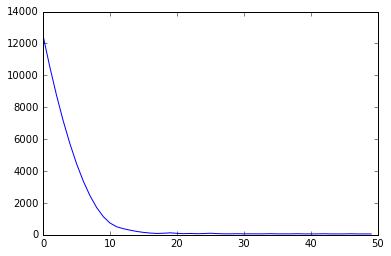

In [1313]:
plt.plot(losses[:50])

## Do It Yourself:

* Adapt our Perceptron to show an adaptive, **decreasing learning rate**: after a number of epochs (e.g. 100), it would make sense to decrease the learning, for instance by a factor of three.
* Implement a form of **early stopping**: stop the training procedure, if the loss doesn't significantly go down anymore for a number of epochs.

## A Perceptron in Theano

We import theano and initialize our random seed:

In [1314]:
import theano
import theano.tensor as T
rng = np.random
rng.seed(156651)

We begin by instantiating the input matrix which we will use (our X matrix of house features) and the output vector which we could like our model to return, i.e. the list of prices for each house. Both consist of floats, hence the `f` at the beginning of `fmatrix` and `fvector`:

In [1315]:
train_input = T.fmatrix('train_input')
train_target = T.fvector('train_output')

What is important is that at this point, both `train_input` and `train_target` are purely symbolic variables that don't have an actual value yet. These variables are mere placeholders for when we will actually start using the model. Below, we instantiate our weight metrix containing our parameters. This is not a symbolic variable: it will alreayd have actual values in it, because we initialize it randomly:

In [1316]:
weights = np.asarray(rng.uniform(low=-0.05, high=0.05,
                                 size=(X.shape[1])),
                     dtype='float32')
print(weights)
print(weights.shape)

W = theano.shared(value=weights, name='W', borrow=True)

[-0.04963301  0.04475696 -0.02963052 -0.01821073 -0.04093222  0.0021752
  0.03168588 -0.0228706   0.04216252 -0.00994067 -0.01141965 -0.02260192
 -0.01913692]
(13,)


We make use of a theano variable which can 'shared' and 'borrowed', because every component of our code and system will need access to these numbers during the optimization. We make use of 'float32' floating point numbers, because currently those are they only ones -- apart from integers -- which are fully supported on the GPU architectures on which neural networks are typically trained. We are now ready to define the graph which will represent our model. In our case of a plain regression model, the prediction is simple enough:

In [1317]:
prediction = (train_input * W).sum(axis=1)

At this point, `prediction` is a mere symbolic variable or a node in the modle graph we are constructing: to turn into an actual function which we use, we need to **compile** it. In `theano`, we can do that as follows, by specifying both the input and output that this function will need:

In [1318]:
predict = theano.function([train_input], prediction)

Did you notice that compiling the graph takes a short while? That is because `theano` will try to optimize a function quite heavily, so that it will be fast to use afterwards. We can now already apply this function:

In [1319]:
X = np.array(X, dtype='float32')
predictions = predict(X)
print(predictions.shape)

(506,)


As you can see, we obtain the output vector: its shape already fits our expectations (i.e. a price for each house), but its values will still be worhtless, because our weights are randomly initialized. To find out how well we are currently doing, we need define a function which we can use to measure the cost for a certain state of the model (as we did above), by comparing the current output of the model to the ideal target values which we would have liked to obtain. The cost or objective which we use is the mean squared error. In `theano`, calculating this cost runs largely parallel to the code for `numpy`:

In [1320]:
silver_predictions = T.fvector('silver')
gold_predictions = T.fvector('gold')
y = np.array(y, dtype='float32')

cost = T.mean((silver_predictions - gold_predictions) ** 2)

The symbolic `cost` variable too can be compiled into an actual function:

In [1321]:
mse = theano.function([silver_predictions, gold_predictions], cost)

When we apply the `mse` function, we see that our cost is huge at this point:

In [1322]:
print(mse(predictions, y))

1146.99194336


In [1323]:
def mean_squared_error(y_gold, y_pred):
    return ((y_gold - y_pred) ** 2).mean()

In [1324]:
mean_squared_error(predictions, y)

1146.9921

We are now ready to let the magic happen: in the following block we define a variable that will contain the gradients of our parameters, with respect to the cost function which we defined:

In [1325]:
symbolic_cost = T.mean((prediction - train_target) ** 2)
gradients = T.grad(symbolic_cost, W)

Amazingly, we can now check out the current gradients of each of the 13 parameters in our system:

In [1326]:
get_grads = theano.function([train_input, train_target], gradients)
print(get_grads(X, y))

[ -1.80837784e+02  -8.57805847e+02  -6.75006226e+02  -5.32577467e+00
  -3.53757362e+01  -4.18336609e+02  -4.28877832e+03  -2.55309296e+02
  -5.72623352e+02  -2.54460781e+04  -1.18703381e+03  -2.40647793e+04
  -7.33394226e+02]


We are now ready to start the optimization process. First, we need to specify a `learning_rate` factor and the number of **epochs** we would to use:

In [1327]:
learning_rate = np.float32(0.0000001)
nb_epoch = 500

In [1328]:
print(W.get_value().shape)

(13,)


In [1329]:
updates = [(W, W - np.float32(learning_rate) * gradients)]

train_model = theano.function(
        inputs=[train_input, train_target],
        outputs=symbolic_cost,
        updates=updates,
)

In [1330]:
losses = []
for e in range(nb_epoch):
    c = train_model(X, y)
    print('-> current loss:', c)
    losses.append(c)

-> current loss: 1146.99194336
-> current loss: 1026.00390625
-> current loss: 919.606018066
-> current loss: 826.029541016
-> current loss: 743.720031738
-> current loss: 671.311889648
-> current loss: 607.604858398
-> current loss: 551.544433594
-> current loss: 502.203826904
-> current loss: 458.768859863
-> current loss: 420.523895264
-> current loss: 386.840270996
-> current loss: 357.165405273
-> current loss: 331.013793945
-> current loss: 307.958892822
-> current loss: 287.625732422
-> current loss: 269.684967041
-> current loss: 253.847076416
-> current loss: 239.857681274
-> current loss: 227.493286133
-> current loss: 216.557449341
-> current loss: 206.877593994
-> current loss: 198.302017212
-> current loss: 190.697433472
-> current loss: 183.946746826
-> current loss: 177.947006226
-> current loss: 172.607788086
-> current loss: 167.849578857
-> current loss: 163.602554321
-> current loss: 159.80531311
-> current loss: 156.403930664
-> current loss: 153.350982666
-> curren

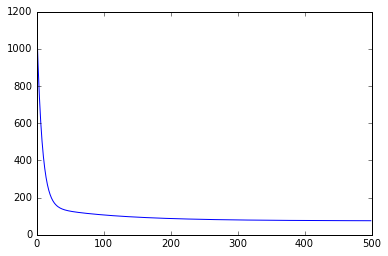

In [1331]:
plt.plot(losses)

In [ ]:
First, we need to re-initialize our shared variable:

In [1338]:
rng.seed(156651)
weights = np.asarray(rng.uniform(low=-0.05, high=0.05,
                                 size=(X.shape[1])),
                     dtype='float32')
W.set_value(weights)

Now we start looping and each time we update our parameters in the light of their respective gradients using a simple update rule:

In [1339]:
losses = []
for e in range(nb_epoch):
    predictions = predict(X)
    curr_loss = mse(predictions, y)
    if e % 50 == 0:
        print('current loss ->', curr_loss)
    losses.append(curr_loss)
    curr_grads = get_grads(X, y)
    curr_weights = W.get_value(borrow=True)
    curr_weights = curr_weights - learning_rate * curr_grads
    W.set_value(curr_weights)

current loss -> 1146.99194336
current loss -> 127.060585022
current loss -> 106.666549683
current loss -> 94.8662643433
current loss -> 87.4759521484
current loss -> 82.8393249512
current loss -> 79.9231872559
current loss -> 78.0820770264
current loss -> 76.9127578735
current loss -> 76.1633071899


As you can see, we obtain a loss curve that looks very similar to our previous one:

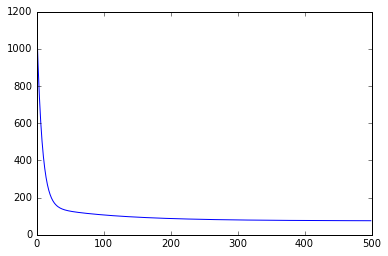

In [1340]:
plt.plot(losses)

## A Perceptron in TensorFlow

(For reference, I include a similar implementation of our perceptron in `Tensorflow`, but we probably won't have tim eto work through block by block...)

In [1382]:
import tensorflow as tf
import numpy as np

In [1383]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target

X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')

In [1384]:
# purely "symbolic variable"
train_input = tf.placeholder(tf.float32, [None, X.shape[1]])

In [1385]:
train_output = tf.placeholder(tf.float32, [None])

In [1386]:
rng.seed(156651)
weights = tf.Variable(np.asarray(rng.uniform(low=-0.05, high=0.05,
                                 size=(X.shape[1])),
                     dtype='float32'))

In [1387]:
model_output = tf.reduce_sum(tf.mul(train_input, weights), 1)

In [1388]:
mse_cost = tf.reduce_mean(tf.square(model_output - train_output),
                          reduction_indices=0)

In [1389]:
train_step = tf.train.GradientDescentOptimizer(0.0000001).minimize(mse_cost)

In [1390]:
init = tf.initialize_all_variables()

In [1391]:
sess = tf.Session()
sess.run(init)

In [1392]:
f = sess.run(model_output, feed_dict={train_input: X})
print(mean_squared_error(f, y))
g = sess.run(mse_cost, feed_dict={train_input: X, train_output: y})
print(g)

1146.99
1146.99


In [1393]:
losses = []
for i in range(500):
    c = sess.run(mse_cost, feed_dict={train_input: X, train_output: y})
    losses.append(c)
    if i % 50 == 0:
        print(c)
    sess.run(train_step, feed_dict={train_input: X, train_output: y})

1146.99
127.061
106.667
94.8663
87.476
82.8393
79.9232
78.0821
76.9128
76.1633


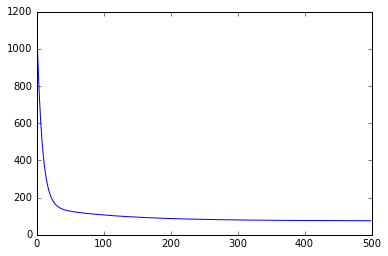

In [1394]:
plt.plot(losses)

---------------------------------